[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

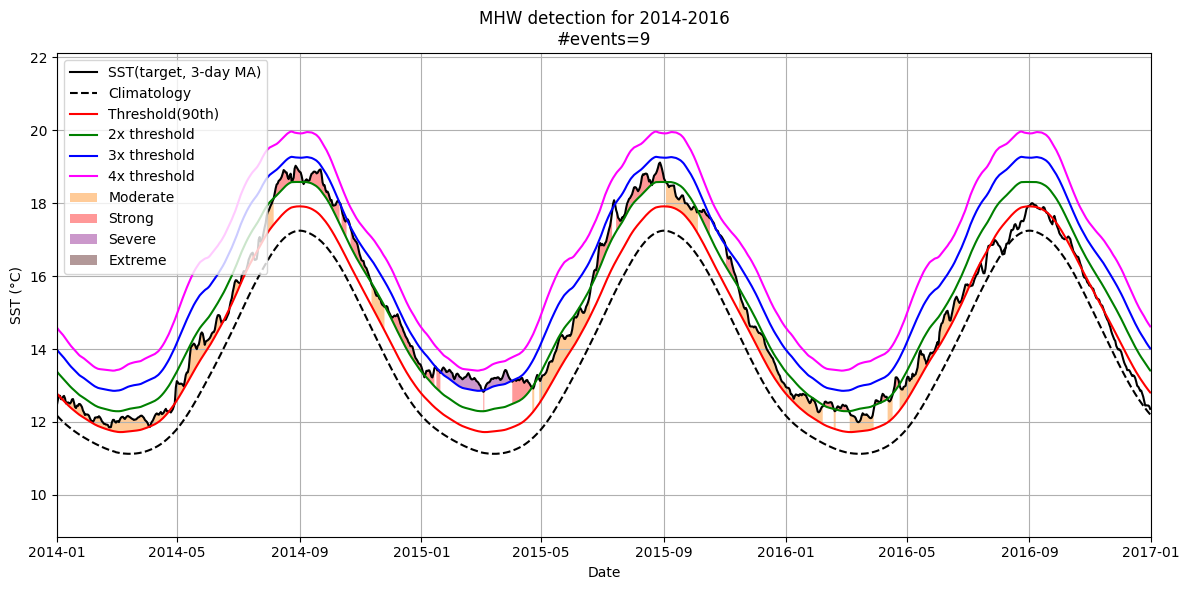

In [6]:
# -*- coding: utf-8 -*-NEP
"""
あらゆる年または複数年連続期間において、
海洋熱波 (Marine Heatwave; MHW) を検出・描画できるスクリプト。

このスクリプトでは、
1) 1982-01-01 ～ 2016-07-05 の期間のSSTを気候期間として読み込み、
   読み込んだデータに先に移動平均（runavg_window 日）を適用して
   climatology（seas, thresh 等）を算出します。
2) 解析対象期間（例：2015～2016）のSSTを同様に移動平均済みデータを用いて解析します。
3) marine.detect() を用いてMHWイベントを検出し、
4) Hobdayら(2016)の定義に基づき4カテゴリ（Moderate/Strong/Severe/Extreme）に分類します。
5) 対象期間のグラフ描画および、各イベントごとの詳細（各カテゴリの日数割合、ピーク時異常値など）をコンソール出力します。

使い方:
  ・必要に応じて lat_min, lat_max, lon_min, lon_max を修正してください。
  ・file_pattern は SST ファイルのパス／名前に合わせて修正してください（{} 部分に年が入ります）。
  ・main() 内の target_years を変更すれば、例：[2015] や range(2015, 2017)（2015～2016連続）などの指定が可能です。
  ・気候期間は clim_start_date, clim_end_date によって日付レベルで指定してください。

(注) 移動平均の取り扱いやプロットのデザインは適宜変更可能です。
"""

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.dates as mdates

# marine.py内のdetect()およびrunavg()を利用（別途marine.pyをご用意ください）
import marine as mhw


# ============================================================================
# SST 読み込み関数
# ============================================================================
def read_sst_ncfiles(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    """
    指定した年リスト（例: range(1982,2017) や [2011]）について、
    file_pattern.format(year) に従い、指定領域（lat_min～lat_max, lon_min～lon_max）
    で SST を空間平均した日次の SST 平均値と、その日付（ordinal 値）の1次元配列を返す。
    """
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        time_var = ds_nc.variables["time"][:]  # shape=(T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        # 日付を ordinal（連続日数）に変換
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        lat_1d = ds_nc.variables["lat"][:]
        lon_1d = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]  # (T, lat, lon)
        ds_nc.close()
        # 対象領域のインデックス
        lat_inds = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]
        lon_inds = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
        # 空間平均（欠損は np.nanmean）
        sst_subset = sst_3d[:, lat_inds[:, np.newaxis], lon_inds]
        sst_mean = np.nanmean(sst_subset, axis=(1, 2))
        t_list.append(t_ordinal)
        sst_list.append(sst_mean)
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list)
    return t_all, sst_all


# ============================================================================
# MHW 検出・描画関数（気候期間を日付レベルで指定）
# ============================================================================
def detect_mhw_for_years(target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         clim_start_date, clim_end_date,
                         runavg_window=11, runavg_isMultiYear=True, pctile=90):
    """
    指定した target_years（例: range(2015,2017)）について、
      (A) 気候期間のSSTを、clim_start_date ～ clim_end_date の期間で読み込み、
          その後 runavg_window 日移動平均を適用して climatology（seas, thresh 等）を算出
      (B) 解析対象期間のSSTも同様に移動平均済みデータを用いて marine.detect() により MHW イベントを検出
    戻り値:
      mhw_res, clim_res, dates_target（dateのリスト）, sst_target_smooth（移動平均済SST）
    """
    # --- (A) 気候期間の SST 読み込み ---
    # 気候期間は、clim_start_date から clim_end_date の年をカバーする
    clim_years_input = range(clim_start_date.year, clim_end_date.year + 1)
    t_clim_all, sst_clim_all = read_sst_ncfiles(clim_years_input, file_pattern, lat_min, lat_max, lon_min, lon_max)
    clim_start_ord = clim_start_date.toordinal()
    clim_end_ord = clim_end_date.toordinal()
    clim_mask = (t_clim_all >= clim_start_ord) & (t_clim_all <= clim_end_ord)
    t_clim = t_clim_all[clim_mask]
    sst_clim = sst_clim_all[clim_mask]
    if len(t_clim) == 0:
        raise ValueError("指定した気候期間内にデータがありません。clim_start_date, clim_end_date を確認してください。")
    # 利用可能な気候期間の実際の年を抽出
    available_clim_years = np.unique([date.fromordinal(t).year for t in t_clim])
    clim_period = [int(available_clim_years[0]), int(available_clim_years[-1])]
    print(f"[INFO] Climatology period (available): {clim_period[0]}-{clim_period[1]}")
    # 移動平均適用（気候期間）
    half = (runavg_window - 1) // 2
    sst_clim_ma = mhw.runavg(sst_clim, w=half, allDates=t_clim, isMultiYear=runavg_isMultiYear)
    print(f"[INFO] Climatology: t shape = {t_clim.shape}, sst shape = {sst_clim_ma.shape}")
    
    # --- (B) 解析対象期間の SST 読み込み ---
    t_target, sst_target = read_sst_ncfiles(target_years, file_pattern, lat_min, lat_max, lon_min, lon_max)
    print(f"[INFO] Target: t shape = {t_target.shape}, sst shape = {sst_target.shape}")
    sst_target_ma = mhw.runavg(sst_target, w=half, allDates=t_target, isMultiYear=runavg_isMultiYear)
    # 対象期間のフィルタリング（target_years全体）
    min_year = min(target_years)
    max_year = max(target_years)
    day1_target = date(min_year, 1, 1).toordinal()
    dayend_target = date(max_year, 12, 31).toordinal()
    idx_target = (t_target >= day1_target) & (t_target <= dayend_target)
    sst_target_smooth = sst_target_ma.copy()
    t_target_sub = t_target[idx_target]
    dates_target = [date.fromordinal(int(x)) for x in t_target[idx_target]]
    
    # --- (C) MHW 検出 ---
    # climatologyPeriod は検出関数内で年単位（整数）として利用されるため、
    # available_clim_years の最初と最後の年を渡す
    mhw_res, clim_res = mhw.detect(
        t_target,
        sst_target_smooth,
        climatologyPeriod=clim_period,
        pctile=pctile,
        windowHalfWidth=5,
        smoothPercentile=True,
        smoothPercentileWidth=31,
        minDuration=5,
        joinAcrossGaps=False,
        maxGap=2,
        maxPadLength=False,
        coldSpells=False,
        alternateClimatology=[t_clim, sst_clim_ma],
        Ly=False
    )
    print(f"[INFO] # of MHW events in target period = {mhw_res['n_events']}")
    
    # --- (D) カテゴリ計算および解析結果のコンソール出力 ---
    sst_final = sst_target_smooth[idx_target]
    seas_sub = clim_res["seas"][idx_target]
    thresh_sub = clim_res["thresh"][idx_target]
    dates_target_sub = dates_target
    
    # アノマリー（SST - climatology）
    cat_value = sst_final - seas_sub
    delta = thresh_sub - seas_sub  # 閾値とclimatologyの差
    # カテゴリ別（Moderate, Strong, Severe, Extreme）に分類
    cat_mod = np.where((cat_value >= delta) & (cat_value < 2 * delta), cat_value, np.nan)
    cat_str = np.where((cat_value >= 2 * delta) & (cat_value < 3 * delta), cat_value, np.nan)
    cat_sev = np.where((cat_value >= 3 * delta) & (cat_value < 4 * delta), cat_value, np.nan)
    cat_ext = np.where(cat_value >= 4 * delta, cat_value, np.nan)
    
    total_days = len(sst_final)
    mod_days = np.sum(~np.isnan(cat_mod))
    str_days = np.sum(~np.isnan(cat_str))
    sev_days = np.sum(~np.isnan(cat_sev))
    ext_days = np.sum(~np.isnan(cat_ext))
    
    print("\n=== Category Days & Fractions (Target Period) ===")
    print(f"  Total days : {total_days} days")
    print(f"  Moderate  : {mod_days} days  -> {100.0 * mod_days / total_days:.2f}%")
    print(f"  Strong    : {str_days} days  -> {100.0 * str_days / total_days:.2f}%")
    print(f"  Severe    : {sev_days} days  -> {100.0 * sev_days / total_days:.2f}%")
    print(f"  Extreme   : {ext_days} days  -> {100.0 * ext_days / total_days:.2f}%\n")
    
    # 各イベントごとの詳細出力
    print(f"[INFO] MHW events (target years={min(target_years)}-{max(target_years)}):")
    dates_array = np.array([d.toordinal() for d in dates_target_sub])
    if mhw_res["n_events"] > 0:
        for i in range(mhw_res["n_events"]):
            start_day = mhw_res["date_start"][i]
            end_day = mhw_res["date_end"][i]
            peak_day = mhw_res["date_peak"][i]
            # イベント期間内のインデックス
            event_idx = np.where((dates_array >= start_day.toordinal()) & (dates_array <= end_day.toordinal()))[0]
            event_len = len(event_idx)
            # 各カテゴリの日数
            ev_mod = np.sum(~np.isnan(cat_mod[event_idx]))
            ev_str = np.sum(~np.isnan(cat_str[event_idx]))
            ev_sev = np.sum(~np.isnan(cat_sev[event_idx]))
            ev_ext = np.sum(~np.isnan(cat_ext[event_idx]))
            # peak時の異常値（SST - climatology）
            try:
                peak_idx = dates_target_sub.index(peak_day)
                peak_anomaly = sst_final[peak_idx] - seas_sub[peak_idx]
            except ValueError:
                peak_anomaly = np.nan
            print(f"  Event #{i+1}: start={start_day}, end={end_day}, peak={peak_day} (anomaly: {peak_anomaly:.3f} °C), duration={mhw_res['duration'][i]} days")
            print(f"      total days: {event_len}")
            if event_len > 0:
                print(f"        Moderate : {ev_mod} days -> {100.0 * ev_mod / event_len:.2f}%")
                print(f"        Strong   : {ev_str} days -> {100.0 * ev_str / event_len:.2f}%")
                print(f"        Severe   : {ev_sev} days -> {100.0 * ev_sev / event_len:.2f}%")
                print(f"        Extreme  : {ev_ext} days -> {100.0 * ev_ext / event_len:.2f}%")
            else:
                print("        (No days in this event?)")
    else:
        print("No events detected.")
    
    # --- (E) プロット ---
    sst_ma = np.ma.masked_invalid(sst_final)
    seas_ma = np.ma.masked_invalid(seas_sub)
    thresh_ma = np.ma.masked_invalid(thresh_sub)
    cat_mod_ma = np.ma.masked_invalid(cat_mod)
    cat_str_ma = np.ma.masked_invalid(cat_str)
    cat_sev_ma = np.ma.masked_invalid(cat_sev)
    cat_ext_ma = np.ma.masked_invalid(cat_ext)
    
    thresh2x_ma = seas_ma + 2 * (thresh_ma - seas_ma)
    thresh3x_ma = seas_ma + 3 * (thresh_ma - seas_ma)
    thresh4x_ma = seas_ma + 4 * (thresh_ma - seas_ma)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_target_sub, sst_ma, color='black', linestyle='-', label=f"SST(target, {runavg_window}-day MA)")
    ax.plot(dates_target_sub, seas_ma, color='black', linestyle='--', label="Climatology")
    ax.plot(dates_target_sub, thresh_ma, color='red', linestyle='-', label=f"Threshold({pctile}th)")
    ax.plot(dates_target_sub, thresh2x_ma, color='green', linestyle='-', label="2x threshold")
    ax.plot(dates_target_sub, thresh3x_ma, color='blue', linestyle='-', label="3x threshold")
    ax.plot(dates_target_sub, thresh4x_ma, color='magenta', linestyle='-', label="4x threshold")
    
    ax.fill_between(dates_target_sub,
                    seas_ma + (thresh_ma - seas_ma),
                    seas_ma + cat_mod_ma,
                    where=~np.isnan(cat_mod_ma),
                    facecolor=(1.0, 0.6, 0.2), alpha=0.5, label="Moderate")
    ax.fill_between(dates_target_sub,
                    seas_ma + 2 * (thresh_ma - seas_ma),
                    seas_ma + cat_str_ma,
                    where=~np.isnan(cat_str_ma),
                    facecolor=(1.0, 0.2, 0.2), alpha=0.5, label="Strong")
    ax.fill_between(dates_target_sub,
                    seas_ma + 3 * (thresh_ma - seas_ma),
                    seas_ma + cat_sev_ma,
                    where=~np.isnan(cat_sev_ma),
                    facecolor=(0.6, 0.2, 0.6), alpha=0.5, label="Severe")
    ax.fill_between(dates_target_sub,
                    seas_ma + 4 * (thresh_ma - seas_ma),
                    seas_ma + cat_ext_ma,
                    where=~np.isnan(cat_ext_ma),
                    facecolor=(0.4, 0.2, 0.2), alpha=0.5, label="Extreme")
    
    ax.set_ylim(np.nanmin(sst_final) - 3, np.nanmax(sst_final) + 3)
    ax.set_xlim(date(min(target_years), 1, 1), date(max(target_years) + 1, 1, 1))
    ax.set_title(f"MHW detection for {min(target_years)}-{max(target_years)}\n#events={mhw_res['n_events']}")
    ax.set_xlabel("Date")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
    return mhw_res, clim_res, dates_target_sub, sst_target_smooth


def main():
    # ======= パラメータ設定 =======
    # 対象領域の設定
    lat_min, lat_max = 30, 57
    lon_min, lon_max = 220, 240
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"  # {} に年が入る
    # 気候期間を日付レベルで指定（例：1982-01-01 ～ 2016-07-05）
    clim_start_date = date(1983, 1, 1)
    clim_end_date = date(2012, 12, 31)
    # 解析対象期間：例：2015～2016
    target_years = range(2014, 2017)
    #target_years = [2012]
    
    detect_mhw_for_years(
        target_years=target_years,
        file_pattern=file_pattern,
        lat_min=lat_min, lat_max=lat_max,
        lon_min=lon_min, lon_max=lon_max,
        clim_start_date=clim_start_date,
        clim_end_date=clim_end_date,
        runavg_window=3,        # 例として 3 日移動平均
        runavg_isMultiYear=True,
        pctile=90
    )


if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

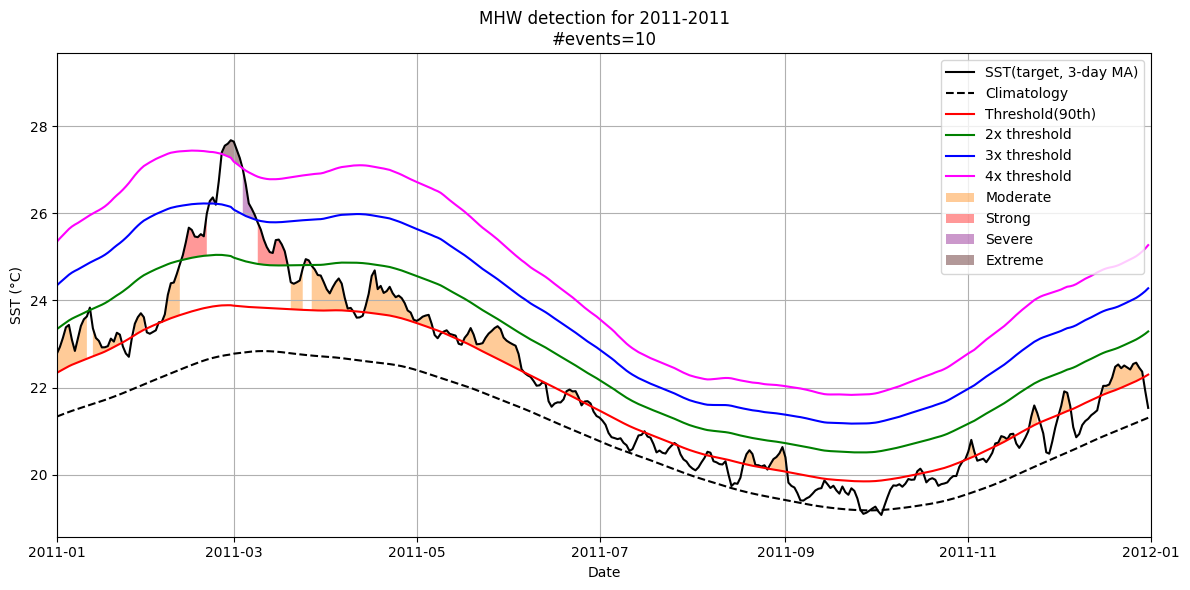

In [4]:
# -*- coding: utf-8 -*-WA
"""
あらゆる年または複数年連続期間において、
海洋熱波 (Marine Heatwave; MHW) を検出・描画できるスクリプト。

このスクリプトでは、
1) 1982-01-01 ～ 2016-07-05 の期間のSSTを気候期間として読み込み、
   読み込んだデータに先に移動平均（runavg_window 日）を適用して
   climatology（seas, thresh 等）を算出します。
2) 解析対象期間（例：2015～2016）のSSTを同様に移動平均済みデータを用いて解析します。
3) marine.detect() を用いてMHWイベントを検出し、
4) Hobdayら(2016)の定義に基づき4カテゴリ（Moderate/Strong/Severe/Extreme）に分類します。
5) 対象期間のグラフ描画および、各イベントごとの詳細（各カテゴリの日数割合、ピーク時異常値など）をコンソール出力します。

使い方:
  ・必要に応じて lat_min, lat_max, lon_min, lon_max を修正してください。
  ・file_pattern は SST ファイルのパス／名前に合わせて修正してください（{} 部分に年が入ります）。
  ・main() 内の target_years を変更すれば、例：[2015] や range(2015, 2017)（2015～2016連続）などの指定が可能です。
  ・気候期間は clim_start_date, clim_end_date によって日付レベルで指定してください。

(注) 移動平均の取り扱いやプロットのデザインは適宜変更可能です。
"""

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.dates as mdates

# marine.py内のdetect()およびrunavg()を利用（別途marine.pyをご用意ください）
import marine as mhw


# ============================================================================
# SST 読み込み関数
# ============================================================================
def read_sst_ncfiles(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    """
    指定した年リスト（例: range(1982,2017) や [2011]）について、
    file_pattern.format(year) に従い、指定領域（lat_min～lat_max, lon_min～lon_max）
    で SST を空間平均した日次の SST 平均値と、その日付（ordinal 値）の1次元配列を返す。
    """
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        time_var = ds_nc.variables["time"][:]  # shape=(T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        # 日付を ordinal（連続日数）に変換
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        lat_1d = ds_nc.variables["lat"][:]
        lon_1d = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]  # (T, lat, lon)
        ds_nc.close()
        # 対象領域のインデックス
        lat_inds = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]
        lon_inds = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
        # 空間平均（欠損は np.nanmean）
        sst_subset = sst_3d[:, lat_inds[:, np.newaxis], lon_inds]
        sst_mean = np.nanmean(sst_subset, axis=(1, 2))
        t_list.append(t_ordinal)
        sst_list.append(sst_mean)
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list)
    return t_all, sst_all


# ============================================================================
# MHW 検出・描画関数（気候期間を日付レベルで指定）
# ============================================================================
def detect_mhw_for_years(target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         clim_start_date, clim_end_date,
                         runavg_window=11, runavg_isMultiYear=True, pctile=90):
    """
    指定した target_years（例: range(2015,2017)）について、
      (A) 気候期間のSSTを、clim_start_date ～ clim_end_date の期間で読み込み、
          その後 runavg_window 日移動平均を適用して climatology（seas, thresh 等）を算出
      (B) 解析対象期間のSSTも同様に移動平均済みデータを用いて marine.detect() により MHW イベントを検出
    戻り値:
      mhw_res, clim_res, dates_target（dateのリスト）, sst_target_smooth（移動平均済SST）
    """
    # --- (A) 気候期間の SST 読み込み ---
    # 気候期間は、clim_start_date から clim_end_date の年をカバーする
    clim_years_input = range(clim_start_date.year, clim_end_date.year + 1)
    t_clim_all, sst_clim_all = read_sst_ncfiles(clim_years_input, file_pattern, lat_min, lat_max, lon_min, lon_max)
    clim_start_ord = clim_start_date.toordinal()
    clim_end_ord = clim_end_date.toordinal()
    clim_mask = (t_clim_all >= clim_start_ord) & (t_clim_all <= clim_end_ord)
    t_clim = t_clim_all[clim_mask]
    sst_clim = sst_clim_all[clim_mask]
    if len(t_clim) == 0:
        raise ValueError("指定した気候期間内にデータがありません。clim_start_date, clim_end_date を確認してください。")
    # 利用可能な気候期間の実際の年を抽出
    available_clim_years = np.unique([date.fromordinal(t).year for t in t_clim])
    clim_period = [int(available_clim_years[0]), int(available_clim_years[-1])]
    print(f"[INFO] Climatology period (available): {clim_period[0]}-{clim_period[1]}")
    # 移動平均適用（気候期間）
    half = (runavg_window - 1) // 2
    sst_clim_ma = mhw.runavg(sst_clim, w=half, allDates=t_clim, isMultiYear=runavg_isMultiYear)
    print(f"[INFO] Climatology: t shape = {t_clim.shape}, sst shape = {sst_clim_ma.shape}")
    
    # --- (B) 解析対象期間の SST 読み込み ---
    t_target, sst_target = read_sst_ncfiles(target_years, file_pattern, lat_min, lat_max, lon_min, lon_max)
    print(f"[INFO] Target: t shape = {t_target.shape}, sst shape = {sst_target.shape}")
    sst_target_ma = mhw.runavg(sst_target, w=half, allDates=t_target, isMultiYear=runavg_isMultiYear)
    # 対象期間のフィルタリング（target_years全体）
    min_year = min(target_years)
    max_year = max(target_years)
    day1_target = date(min_year, 1, 1).toordinal()
    dayend_target = date(max_year, 12, 31).toordinal()
    idx_target = (t_target >= day1_target) & (t_target <= dayend_target)
    sst_target_smooth = sst_target_ma.copy()
    t_target_sub = t_target[idx_target]
    dates_target = [date.fromordinal(int(x)) for x in t_target[idx_target]]
    
    # --- (C) MHW 検出 ---
    # climatologyPeriod は検出関数内で年単位（整数）として利用されるため、
    # available_clim_years の最初と最後の年を渡す
    mhw_res, clim_res = mhw.detect(
        t_target,
        sst_target_smooth,
        climatologyPeriod=clim_period,
        pctile=pctile,
        windowHalfWidth=5,
        smoothPercentile=True,
        smoothPercentileWidth=31,
        minDuration=5,
        joinAcrossGaps=False,
        maxGap=2,
        maxPadLength=False,
        coldSpells=False,
        alternateClimatology=[t_clim, sst_clim_ma],
        Ly=False
    )
    print(f"[INFO] # of MHW events in target period = {mhw_res['n_events']}")
    
    # --- (D) カテゴリ計算および解析結果のコンソール出力 ---
    sst_final = sst_target_smooth[idx_target]
    seas_sub = clim_res["seas"][idx_target]
    thresh_sub = clim_res["thresh"][idx_target]
    dates_target_sub = dates_target
    
    # アノマリー（SST - climatology）
    cat_value = sst_final - seas_sub
    delta = thresh_sub - seas_sub  # 閾値とclimatologyの差
    # カテゴリ別（Moderate, Strong, Severe, Extreme）に分類
    cat_mod = np.where((cat_value >= delta) & (cat_value < 2 * delta), cat_value, np.nan)
    cat_str = np.where((cat_value >= 2 * delta) & (cat_value < 3 * delta), cat_value, np.nan)
    cat_sev = np.where((cat_value >= 3 * delta) & (cat_value < 4 * delta), cat_value, np.nan)
    cat_ext = np.where(cat_value >= 4 * delta, cat_value, np.nan)
    
    total_days = len(sst_final)
    mod_days = np.sum(~np.isnan(cat_mod))
    str_days = np.sum(~np.isnan(cat_str))
    sev_days = np.sum(~np.isnan(cat_sev))
    ext_days = np.sum(~np.isnan(cat_ext))
    
    print("\n=== Category Days & Fractions (Target Period) ===")
    print(f"  Total days : {total_days} days")
    print(f"  Moderate  : {mod_days} days  -> {100.0 * mod_days / total_days:.2f}%")
    print(f"  Strong    : {str_days} days  -> {100.0 * str_days / total_days:.2f}%")
    print(f"  Severe    : {sev_days} days  -> {100.0 * sev_days / total_days:.2f}%")
    print(f"  Extreme   : {ext_days} days  -> {100.0 * ext_days / total_days:.2f}%\n")
    
    # 各イベントごとの詳細出力
    print(f"[INFO] MHW events (target years={min(target_years)}-{max(target_years)}):")
    dates_array = np.array([d.toordinal() for d in dates_target_sub])
    if mhw_res["n_events"] > 0:
        for i in range(mhw_res["n_events"]):
            start_day = mhw_res["date_start"][i]
            end_day = mhw_res["date_end"][i]
            peak_day = mhw_res["date_peak"][i]
            # イベント期間内のインデックス
            event_idx = np.where((dates_array >= start_day.toordinal()) & (dates_array <= end_day.toordinal()))[0]
            event_len = len(event_idx)
            # 各カテゴリの日数
            ev_mod = np.sum(~np.isnan(cat_mod[event_idx]))
            ev_str = np.sum(~np.isnan(cat_str[event_idx]))
            ev_sev = np.sum(~np.isnan(cat_sev[event_idx]))
            ev_ext = np.sum(~np.isnan(cat_ext[event_idx]))
            # peak時の異常値（SST - climatology）
            try:
                peak_idx = dates_target_sub.index(peak_day)
                peak_anomaly = sst_final[peak_idx] - seas_sub[peak_idx]
            except ValueError:
                peak_anomaly = np.nan
            print(f"  Event #{i+1}: start={start_day}, end={end_day}, peak={peak_day} (anomaly: {peak_anomaly:.3f} °C), duration={mhw_res['duration'][i]} days")
            print(f"      total days: {event_len}")
            if event_len > 0:
                print(f"        Moderate : {ev_mod} days -> {100.0 * ev_mod / event_len:.2f}%")
                print(f"        Strong   : {ev_str} days -> {100.0 * ev_str / event_len:.2f}%")
                print(f"        Severe   : {ev_sev} days -> {100.0 * ev_sev / event_len:.2f}%")
                print(f"        Extreme  : {ev_ext} days -> {100.0 * ev_ext / event_len:.2f}%")
            else:
                print("        (No days in this event?)")
    else:
        print("No events detected.")
    
    # --- (E) プロット ---
    sst_ma = np.ma.masked_invalid(sst_final)
    seas_ma = np.ma.masked_invalid(seas_sub)
    thresh_ma = np.ma.masked_invalid(thresh_sub)
    cat_mod_ma = np.ma.masked_invalid(cat_mod)
    cat_str_ma = np.ma.masked_invalid(cat_str)
    cat_sev_ma = np.ma.masked_invalid(cat_sev)
    cat_ext_ma = np.ma.masked_invalid(cat_ext)
    
    thresh2x_ma = seas_ma + 2 * (thresh_ma - seas_ma)
    thresh3x_ma = seas_ma + 3 * (thresh_ma - seas_ma)
    thresh4x_ma = seas_ma + 4 * (thresh_ma - seas_ma)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_target_sub, sst_ma, color='black', linestyle='-', label=f"SST(target, {runavg_window}-day MA)")
    ax.plot(dates_target_sub, seas_ma, color='black', linestyle='--', label="Climatology")
    ax.plot(dates_target_sub, thresh_ma, color='red', linestyle='-', label=f"Threshold({pctile}th)")
    ax.plot(dates_target_sub, thresh2x_ma, color='green', linestyle='-', label="2x threshold")
    ax.plot(dates_target_sub, thresh3x_ma, color='blue', linestyle='-', label="3x threshold")
    ax.plot(dates_target_sub, thresh4x_ma, color='magenta', linestyle='-', label="4x threshold")
    
    ax.fill_between(dates_target_sub,
                    seas_ma + (thresh_ma - seas_ma),
                    seas_ma + cat_mod_ma,
                    where=~np.isnan(cat_mod_ma),
                    facecolor=(1.0, 0.6, 0.2), alpha=0.5, label="Moderate")
    ax.fill_between(dates_target_sub,
                    seas_ma + 2 * (thresh_ma - seas_ma),
                    seas_ma + cat_str_ma,
                    where=~np.isnan(cat_str_ma),
                    facecolor=(1.0, 0.2, 0.2), alpha=0.5, label="Strong")
    ax.fill_between(dates_target_sub,
                    seas_ma + 3 * (thresh_ma - seas_ma),
                    seas_ma + cat_sev_ma,
                    where=~np.isnan(cat_sev_ma),
                    facecolor=(0.6, 0.2, 0.6), alpha=0.5, label="Severe")
    ax.fill_between(dates_target_sub,
                    seas_ma + 4 * (thresh_ma - seas_ma),
                    seas_ma + cat_ext_ma,
                    where=~np.isnan(cat_ext_ma),
                    facecolor=(0.4, 0.2, 0.2), alpha=0.5, label="Extreme")
    
    ax.set_ylim(np.nanmin(sst_final) - 0.5, np.nanmax(sst_final) + 2)
    ax.set_xlim(date(min(target_years), 1, 1), date(max(target_years) + 1, 1, 1))
    ax.set_title(f"MHW detection for {min(target_years)}-{max(target_years)}\n#events={mhw_res['n_events']}")
    ax.set_xlabel("Date")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    
    return mhw_res, clim_res, dates_target_sub, sst_target_smooth


def main():
    # ======= パラメータ設定 =======
    # 対象領域の設定
    lat_min, lat_max = -33, -27
    lon_min, lon_max = 110, 117
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"  # {} に年が入る
    # 気候期間を日付レベルで指定（例：1982-01-01 ～ 2016-07-05）
    clim_start_date = date(1983, 1, 1)
    clim_end_date = date(2012, 12, 31)
    # 解析対象期間：例：2015～2016
    #target_years = range(2011, 2013)
    target_years = [2011]
    
    detect_mhw_for_years(
        target_years=target_years,
        file_pattern=file_pattern,
        lat_min=lat_min, lat_max=lat_max,
        lon_min=lon_min, lon_max=lon_max,
        clim_start_date=clim_start_date,
        clim_end_date=clim_end_date,
        runavg_window=3,        # 例として 3 日移動平均
        runavg_isMultiYear=True,
        pctile=90
    )


if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

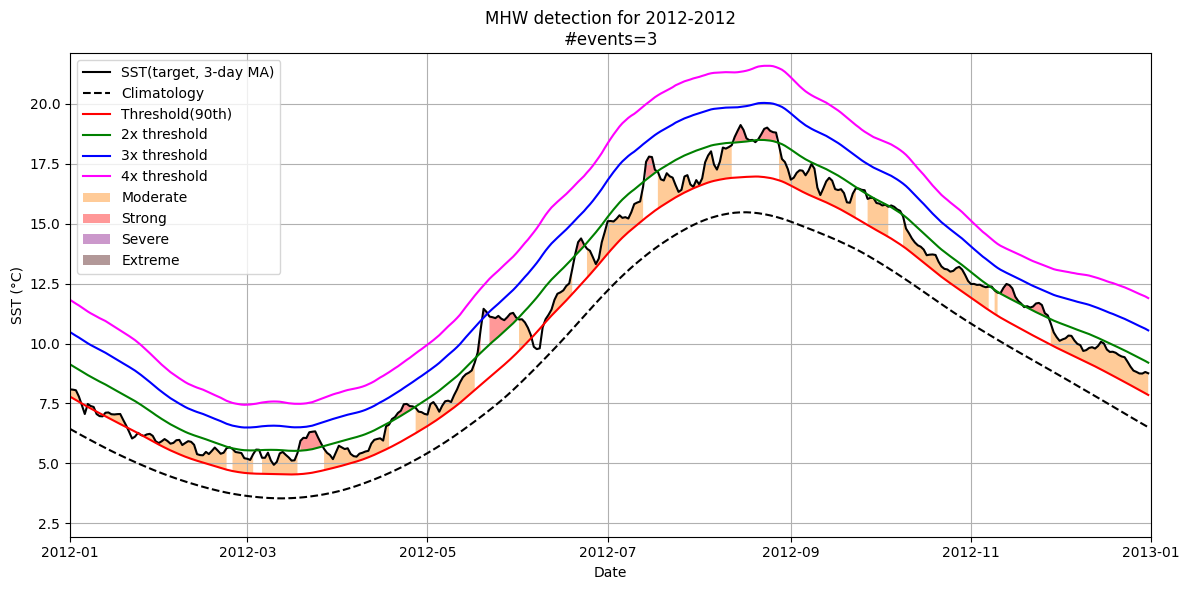

In [7]:
# -*- coding: utf-8 -*-NWA
"""
あらゆる年または複数年連続期間において、
海洋熱波 (Marine Heatwave; MHW) を検出・描画できるスクリプト。

このスクリプトでは、
1) 1982-01-01 ～ 2016-07-05 の期間のSSTを気候期間として読み込み、
   読み込んだデータに先に移動平均（runavg_window 日）を適用して
   climatology（seas, thresh 等）を算出します。
2) 解析対象期間（例：2015～2016）のSSTを同様に移動平均済みデータを用いて解析します。
3) marine.detect() を用いてMHWイベントを検出し、
4) Hobdayら(2016)の定義に基づき4カテゴリ（Moderate/Strong/Severe/Extreme）に分類します。
5) 対象期間のグラフ描画および、各イベントごとの詳細（各カテゴリの日数割合、ピーク時異常値など）をコンソール出力します。

使い方:
  ・必要に応じて lat_min, lat_max, lon_min, lon_max を修正してください。
  ・file_pattern は SST ファイルのパス／名前に合わせて修正してください（{} 部分に年が入ります）。
  ・main() 内の target_years を変更すれば、例：[2015] や range(2015, 2017)（2015～2016連続）などの指定が可能です。
  ・気候期間は clim_start_date, clim_end_date によって日付レベルで指定してください。

(注) 移動平均の取り扱いやプロットのデザインは適宜変更可能です。
"""

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.dates as mdates

# marine.py内のdetect()およびrunavg()を利用（別途marine.pyをご用意ください）
import marine as mhw


# ============================================================================
# SST 読み込み関数
# ============================================================================
def read_sst_ncfiles(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    """
    指定した年リスト（例: range(1982,2017) や [2011]）について、
    file_pattern.format(year) に従い、指定領域（lat_min～lat_max, lon_min～lon_max）
    で SST を空間平均した日次の SST 平均値と、その日付（ordinal 値）の1次元配列を返す。
    """
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        time_var = ds_nc.variables["time"][:]  # shape=(T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        # 日付を ordinal（連続日数）に変換
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        lat_1d = ds_nc.variables["lat"][:]
        lon_1d = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]  # (T, lat, lon)
        ds_nc.close()
        # 対象領域のインデックス
        lat_inds = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]
        lon_inds = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
        # 空間平均（欠損は np.nanmean）
        sst_subset = sst_3d[:, lat_inds[:, np.newaxis], lon_inds]
        sst_mean = np.nanmean(sst_subset, axis=(1, 2))
        t_list.append(t_ordinal)
        sst_list.append(sst_mean)
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list)
    return t_all, sst_all


# ============================================================================
# MHW 検出・描画関数（気候期間を日付レベルで指定）
# ============================================================================
def detect_mhw_for_years(target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         clim_start_date, clim_end_date,
                         runavg_window=11, runavg_isMultiYear=True, pctile=90):
    """
    指定した target_years（例: range(2015,2017)）について、
      (A) 気候期間のSSTを、clim_start_date ～ clim_end_date の期間で読み込み、
          その後 runavg_window 日移動平均を適用して climatology（seas, thresh 等）を算出
      (B) 解析対象期間のSSTも同様に移動平均済みデータを用いて marine.detect() により MHW イベントを検出
    戻り値:
      mhw_res, clim_res, dates_target（dateのリスト）, sst_target_smooth（移動平均済SST）
    """
    # --- (A) 気候期間の SST 読み込み ---
    # 気候期間は、clim_start_date から clim_end_date の年をカバーする
    clim_years_input = range(clim_start_date.year, clim_end_date.year + 1)
    t_clim_all, sst_clim_all = read_sst_ncfiles(clim_years_input, file_pattern, lat_min, lat_max, lon_min, lon_max)
    clim_start_ord = clim_start_date.toordinal()
    clim_end_ord = clim_end_date.toordinal()
    clim_mask = (t_clim_all >= clim_start_ord) & (t_clim_all <= clim_end_ord)
    t_clim = t_clim_all[clim_mask]
    sst_clim = sst_clim_all[clim_mask]
    if len(t_clim) == 0:
        raise ValueError("指定した気候期間内にデータがありません。clim_start_date, clim_end_date を確認してください。")
    # 利用可能な気候期間の実際の年を抽出
    available_clim_years = np.unique([date.fromordinal(t).year for t in t_clim])
    clim_period = [int(available_clim_years[0]), int(available_clim_years[-1])]
    print(f"[INFO] Climatology period (available): {clim_period[0]}-{clim_period[1]}")
    # 移動平均適用（気候期間）
    half = (runavg_window - 1) // 2
    sst_clim_ma = mhw.runavg(sst_clim, w=half, allDates=t_clim, isMultiYear=runavg_isMultiYear)
    print(f"[INFO] Climatology: t shape = {t_clim.shape}, sst shape = {sst_clim_ma.shape}")
    
    # --- (B) 解析対象期間の SST 読み込み ---
    t_target, sst_target = read_sst_ncfiles(target_years, file_pattern, lat_min, lat_max, lon_min, lon_max)
    print(f"[INFO] Target: t shape = {t_target.shape}, sst shape = {sst_target.shape}")
    sst_target_ma = mhw.runavg(sst_target, w=half, allDates=t_target, isMultiYear=runavg_isMultiYear)
    # 対象期間のフィルタリング（target_years全体）
    min_year = min(target_years)
    max_year = max(target_years)
    day1_target = date(min_year, 1, 1).toordinal()
    dayend_target = date(max_year, 12, 31).toordinal()
    idx_target = (t_target >= day1_target) & (t_target <= dayend_target)
    sst_target_smooth = sst_target_ma.copy()
    t_target_sub = t_target[idx_target]
    dates_target = [date.fromordinal(int(x)) for x in t_target[idx_target]]
    
    # --- (C) MHW 検出 ---
    # climatologyPeriod は検出関数内で年単位（整数）として利用されるため、
    # available_clim_years の最初と最後の年を渡す
    mhw_res, clim_res = mhw.detect(
        t_target,
        sst_target_smooth,
        climatologyPeriod=clim_period,
        pctile=pctile,
        windowHalfWidth=5,
        smoothPercentile=True,
        smoothPercentileWidth=31,
        minDuration=5,
        joinAcrossGaps=False,
        maxGap=2,
        maxPadLength=False,
        coldSpells=False,
        alternateClimatology=[t_clim, sst_clim_ma],
        Ly=False
    )
    print(f"[INFO] # of MHW events in target period = {mhw_res['n_events']}")
    
    # --- (D) カテゴリ計算および解析結果のコンソール出力 ---
    sst_final = sst_target_smooth[idx_target]
    seas_sub = clim_res["seas"][idx_target]
    thresh_sub = clim_res["thresh"][idx_target]
    dates_target_sub = dates_target
    
    # アノマリー（SST - climatology）
    cat_value = sst_final - seas_sub
    delta = thresh_sub - seas_sub  # 閾値とclimatologyの差
    # カテゴリ別（Moderate, Strong, Severe, Extreme）に分類
    cat_mod = np.where((cat_value >= delta) & (cat_value < 2 * delta), cat_value, np.nan)
    cat_str = np.where((cat_value >= 2 * delta) & (cat_value < 3 * delta), cat_value, np.nan)
    cat_sev = np.where((cat_value >= 3 * delta) & (cat_value < 4 * delta), cat_value, np.nan)
    cat_ext = np.where(cat_value >= 4 * delta, cat_value, np.nan)
    
    total_days = len(sst_final)
    mod_days = np.sum(~np.isnan(cat_mod))
    str_days = np.sum(~np.isnan(cat_str))
    sev_days = np.sum(~np.isnan(cat_sev))
    ext_days = np.sum(~np.isnan(cat_ext))
    
    print("\n=== Category Days & Fractions (Target Period) ===")
    print(f"  Total days : {total_days} days")
    print(f"  Moderate  : {mod_days} days  -> {100.0 * mod_days / total_days:.2f}%")
    print(f"  Strong    : {str_days} days  -> {100.0 * str_days / total_days:.2f}%")
    print(f"  Severe    : {sev_days} days  -> {100.0 * sev_days / total_days:.2f}%")
    print(f"  Extreme   : {ext_days} days  -> {100.0 * ext_days / total_days:.2f}%\n")
    
    # 各イベントごとの詳細出力
    print(f"[INFO] MHW events (target years={min(target_years)}-{max(target_years)}):")
    dates_array = np.array([d.toordinal() for d in dates_target_sub])
    if mhw_res["n_events"] > 0:
        for i in range(mhw_res["n_events"]):
            start_day = mhw_res["date_start"][i]
            end_day = mhw_res["date_end"][i]
            peak_day = mhw_res["date_peak"][i]
            # イベント期間内のインデックス
            event_idx = np.where((dates_array >= start_day.toordinal()) & (dates_array <= end_day.toordinal()))[0]
            event_len = len(event_idx)
            # 各カテゴリの日数
            ev_mod = np.sum(~np.isnan(cat_mod[event_idx]))
            ev_str = np.sum(~np.isnan(cat_str[event_idx]))
            ev_sev = np.sum(~np.isnan(cat_sev[event_idx]))
            ev_ext = np.sum(~np.isnan(cat_ext[event_idx]))
            # peak時の異常値（SST - climatology）
            try:
                peak_idx = dates_target_sub.index(peak_day)
                peak_anomaly = sst_final[peak_idx] - seas_sub[peak_idx]
            except ValueError:
                peak_anomaly = np.nan
            print(f"  Event #{i+1}: start={start_day}, end={end_day}, peak={peak_day} (anomaly: {peak_anomaly:.3f} °C), duration={mhw_res['duration'][i]} days")
            print(f"      total days: {event_len}")
            if event_len > 0:
                print(f"        Moderate : {ev_mod} days -> {100.0 * ev_mod / event_len:.2f}%")
                print(f"        Strong   : {ev_str} days -> {100.0 * ev_str / event_len:.2f}%")
                print(f"        Severe   : {ev_sev} days -> {100.0 * ev_sev / event_len:.2f}%")
                print(f"        Extreme  : {ev_ext} days -> {100.0 * ev_ext / event_len:.2f}%")
            else:
                print("        (No days in this event?)")
    else:
        print("No events detected.")
    
    # --- (E) プロット ---
    sst_ma = np.ma.masked_invalid(sst_final)
    seas_ma = np.ma.masked_invalid(seas_sub)
    thresh_ma = np.ma.masked_invalid(thresh_sub)
    cat_mod_ma = np.ma.masked_invalid(cat_mod)
    cat_str_ma = np.ma.masked_invalid(cat_str)
    cat_sev_ma = np.ma.masked_invalid(cat_sev)
    cat_ext_ma = np.ma.masked_invalid(cat_ext)
    
    thresh2x_ma = seas_ma + 2 * (thresh_ma - seas_ma)
    thresh3x_ma = seas_ma + 3 * (thresh_ma - seas_ma)
    thresh4x_ma = seas_ma + 4 * (thresh_ma - seas_ma)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_target_sub, sst_ma, color='black', linestyle='-', label=f"SST(target, {runavg_window}-day MA)")
    ax.plot(dates_target_sub, seas_ma, color='black', linestyle='--', label="Climatology")
    ax.plot(dates_target_sub, thresh_ma, color='red', linestyle='-', label=f"Threshold({pctile}th)")
    ax.plot(dates_target_sub, thresh2x_ma, color='green', linestyle='-', label="2x threshold")
    ax.plot(dates_target_sub, thresh3x_ma, color='blue', linestyle='-', label="3x threshold")
    ax.plot(dates_target_sub, thresh4x_ma, color='magenta', linestyle='-', label="4x threshold")
    
    ax.fill_between(dates_target_sub,
                    seas_ma + (thresh_ma - seas_ma),
                    seas_ma + cat_mod_ma,
                    where=~np.isnan(cat_mod_ma),
                    facecolor=(1.0, 0.6, 0.2), alpha=0.5, label="Moderate")
    ax.fill_between(dates_target_sub,
                    seas_ma + 2 * (thresh_ma - seas_ma),
                    seas_ma + cat_str_ma,
                    where=~np.isnan(cat_str_ma),
                    facecolor=(1.0, 0.2, 0.2), alpha=0.5, label="Strong")
    ax.fill_between(dates_target_sub,
                    seas_ma + 3 * (thresh_ma - seas_ma),
                    seas_ma + cat_sev_ma,
                    where=~np.isnan(cat_sev_ma),
                    facecolor=(0.6, 0.2, 0.6), alpha=0.5, label="Severe")
    ax.fill_between(dates_target_sub,
                    seas_ma + 4 * (thresh_ma - seas_ma),
                    seas_ma + cat_ext_ma,
                    where=~np.isnan(cat_ext_ma),
                    facecolor=(0.4, 0.2, 0.2), alpha=0.5, label="Extreme")
    
    ax.set_ylim(np.nanmin(sst_final) - 3, np.nanmax(sst_final) + 3)
    ax.set_xlim(date(min(target_years), 1, 1), date(max(target_years) + 1, 1, 1))
    ax.set_title(f"MHW detection for {min(target_years)}-{max(target_years)}\n#events={mhw_res['n_events']}")
    ax.set_xlabel("Date")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
    return mhw_res, clim_res, dates_target_sub, sst_target_smooth


def main():
    # ======= パラメータ設定 =======
    # 対象領域の設定
    lat_min, lat_max = 42, 44.5
    lon_min, lon_max = 291, 295
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"  # {} に年が入る
    # 気候期間を日付レベルで指定（例：1982-01-01 ～ 2016-07-05）
    clim_start_date = date(1983, 1, 1)
    clim_end_date = date(2012, 12, 31)
    # 解析対象期間：例：2015～2016
    #target_years = range(2011, 2013)
    target_years = [2012]
    
    detect_mhw_for_years(
        target_years=target_years,
        file_pattern=file_pattern,
        lat_min=lat_min, lat_max=lat_max,
        lon_min=lon_min, lon_max=lon_max,
        clim_start_date=clim_start_date,
        clim_end_date=clim_end_date,
        runavg_window=3,        # 例として 3 日移動平均
        runavg_isMultiYear=True,
        pctile=90
    )


if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

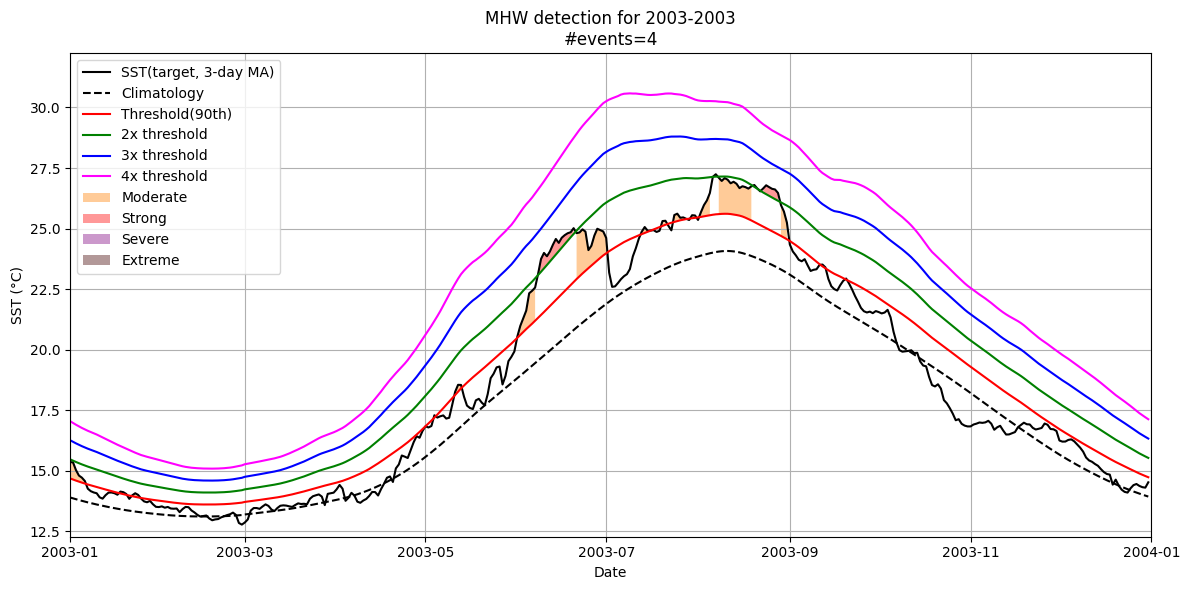

In [9]:
# -*- coding: utf-8 -*-MED
"""
あらゆる年または複数年連続期間において、
海洋熱波 (Marine Heatwave; MHW) を検出・描画できるスクリプト。

このスクリプトでは、
1) 1982-01-01 ～ 2016-07-05 の期間のSSTを気候期間として読み込み、
   読み込んだデータに先に移動平均（runavg_window 日）を適用して
   climatology（seas, thresh 等）を算出します。
2) 解析対象期間（例：2015～2016）のSSTを同様に移動平均済みデータを用いて解析します。
3) marine.detect() を用いてMHWイベントを検出し、
4) Hobdayら(2016)の定義に基づき4カテゴリ（Moderate/Strong/Severe/Extreme）に分類します。
5) 対象期間のグラフ描画および、各イベントごとの詳細（各カテゴリの日数割合、ピーク時異常値など）をコンソール出力します。

使い方:
  ・必要に応じて lat_min, lat_max, lon_min, lon_max を修正してください。
  ・file_pattern は SST ファイルのパス／名前に合わせて修正してください（{} 部分に年が入ります）。
  ・main() 内の target_years を変更すれば、例：[2015] や range(2015, 2017)（2015～2016連続）などの指定が可能です。
  ・気候期間は clim_start_date, clim_end_date によって日付レベルで指定してください。

(注) 移動平均の取り扱いやプロットのデザインは適宜変更可能です。
"""

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.dates as mdates

# marine.py内のdetect()およびrunavg()を利用（別途marine.pyをご用意ください）
import marine as mhw


# ============================================================================
# SST 読み込み関数
# ============================================================================
def read_sst_ncfiles(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    """
    指定した年リスト（例: range(1982,2017) や [2011]）について、
    file_pattern.format(year) に従い、指定領域（lat_min～lat_max, lon_min～lon_max）
    で SST を空間平均した日次の SST 平均値と、その日付（ordinal 値）の1次元配列を返す。
    """
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        time_var = ds_nc.variables["time"][:]  # shape=(T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        # 日付を ordinal（連続日数）に変換
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        lat_1d = ds_nc.variables["lat"][:]
        lon_1d = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]  # (T, lat, lon)
        ds_nc.close()
        # 対象領域のインデックス
        lat_inds = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]
        lon_inds = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
        # 空間平均（欠損は np.nanmean）
        sst_subset = sst_3d[:, lat_inds[:, np.newaxis], lon_inds]
        sst_mean = np.nanmean(sst_subset, axis=(1, 2))
        t_list.append(t_ordinal)
        sst_list.append(sst_mean)
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list)
    return t_all, sst_all


# ============================================================================
# MHW 検出・描画関数（気候期間を日付レベルで指定）
# ============================================================================
def detect_mhw_for_years(target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         clim_start_date, clim_end_date,
                         runavg_window=11, runavg_isMultiYear=True, pctile=90):
    """
    指定した target_years（例: range(2015,2017)）について、
      (A) 気候期間のSSTを、clim_start_date ～ clim_end_date の期間で読み込み、
          その後 runavg_window 日移動平均を適用して climatology（seas, thresh 等）を算出
      (B) 解析対象期間のSSTも同様に移動平均済みデータを用いて marine.detect() により MHW イベントを検出
    戻り値:
      mhw_res, clim_res, dates_target（dateのリスト）, sst_target_smooth（移動平均済SST）
    """
    # --- (A) 気候期間の SST 読み込み ---
    # 気候期間は、clim_start_date から clim_end_date の年をカバーする
    clim_years_input = range(clim_start_date.year, clim_end_date.year + 1)
    t_clim_all, sst_clim_all = read_sst_ncfiles(clim_years_input, file_pattern, lat_min, lat_max, lon_min, lon_max)
    clim_start_ord = clim_start_date.toordinal()
    clim_end_ord = clim_end_date.toordinal()
    clim_mask = (t_clim_all >= clim_start_ord) & (t_clim_all <= clim_end_ord)
    t_clim = t_clim_all[clim_mask]
    sst_clim = sst_clim_all[clim_mask]
    if len(t_clim) == 0:
        raise ValueError("指定した気候期間内にデータがありません。clim_start_date, clim_end_date を確認してください。")
    # 利用可能な気候期間の実際の年を抽出
    available_clim_years = np.unique([date.fromordinal(t).year for t in t_clim])
    clim_period = [int(available_clim_years[0]), int(available_clim_years[-1])]
    print(f"[INFO] Climatology period (available): {clim_period[0]}-{clim_period[1]}")
    # 移動平均適用（気候期間）
    half = (runavg_window - 1) // 2
    sst_clim_ma = mhw.runavg(sst_clim, w=half, allDates=t_clim, isMultiYear=runavg_isMultiYear)
    print(f"[INFO] Climatology: t shape = {t_clim.shape}, sst shape = {sst_clim_ma.shape}")
    
    # --- (B) 解析対象期間の SST 読み込み ---
    t_target, sst_target = read_sst_ncfiles(target_years, file_pattern, lat_min, lat_max, lon_min, lon_max)
    print(f"[INFO] Target: t shape = {t_target.shape}, sst shape = {sst_target.shape}")
    sst_target_ma = mhw.runavg(sst_target, w=half, allDates=t_target, isMultiYear=runavg_isMultiYear)
    # 対象期間のフィルタリング（target_years全体）
    min_year = min(target_years)
    max_year = max(target_years)
    day1_target = date(min_year, 1, 1).toordinal()
    dayend_target = date(max_year, 12, 31).toordinal()
    idx_target = (t_target >= day1_target) & (t_target <= dayend_target)
    sst_target_smooth = sst_target_ma.copy()
    t_target_sub = t_target[idx_target]
    dates_target = [date.fromordinal(int(x)) for x in t_target[idx_target]]
    
    # --- (C) MHW 検出 ---
    # climatologyPeriod は検出関数内で年単位（整数）として利用されるため、
    # available_clim_years の最初と最後の年を渡す
    mhw_res, clim_res = mhw.detect(
        t_target,
        sst_target_smooth,
        climatologyPeriod=clim_period,
        pctile=pctile,
        windowHalfWidth=5,
        smoothPercentile=True,
        smoothPercentileWidth=31,
        minDuration=5,
        joinAcrossGaps=False,
        maxGap=2,
        maxPadLength=False,
        coldSpells=False,
        alternateClimatology=[t_clim, sst_clim_ma],
        Ly=False
    )
    print(f"[INFO] # of MHW events in target period = {mhw_res['n_events']}")
    
    # --- (D) カテゴリ計算および解析結果のコンソール出力 ---
    sst_final = sst_target_smooth[idx_target]
    seas_sub = clim_res["seas"][idx_target]
    thresh_sub = clim_res["thresh"][idx_target]
    dates_target_sub = dates_target
    
    # アノマリー（SST - climatology）
    cat_value = sst_final - seas_sub
    delta = thresh_sub - seas_sub  # 閾値とclimatologyの差
    # カテゴリ別（Moderate, Strong, Severe, Extreme）に分類
    cat_mod = np.where((cat_value >= delta) & (cat_value < 2 * delta), cat_value, np.nan)
    cat_str = np.where((cat_value >= 2 * delta) & (cat_value < 3 * delta), cat_value, np.nan)
    cat_sev = np.where((cat_value >= 3 * delta) & (cat_value < 4 * delta), cat_value, np.nan)
    cat_ext = np.where(cat_value >= 4 * delta, cat_value, np.nan)
    
    total_days = len(sst_final)
    mod_days = np.sum(~np.isnan(cat_mod))
    str_days = np.sum(~np.isnan(cat_str))
    sev_days = np.sum(~np.isnan(cat_sev))
    ext_days = np.sum(~np.isnan(cat_ext))
    
    print("\n=== Category Days & Fractions (Target Period) ===")
    print(f"  Total days : {total_days} days")
    print(f"  Moderate  : {mod_days} days  -> {100.0 * mod_days / total_days:.2f}%")
    print(f"  Strong    : {str_days} days  -> {100.0 * str_days / total_days:.2f}%")
    print(f"  Severe    : {sev_days} days  -> {100.0 * sev_days / total_days:.2f}%")
    print(f"  Extreme   : {ext_days} days  -> {100.0 * ext_days / total_days:.2f}%\n")
    
    # 各イベントごとの詳細出力
    print(f"[INFO] MHW events (target years={min(target_years)}-{max(target_years)}):")
    dates_array = np.array([d.toordinal() for d in dates_target_sub])
    if mhw_res["n_events"] > 0:
        for i in range(mhw_res["n_events"]):
            start_day = mhw_res["date_start"][i]
            end_day = mhw_res["date_end"][i]
            peak_day = mhw_res["date_peak"][i]
            # イベント期間内のインデックス
            event_idx = np.where((dates_array >= start_day.toordinal()) & (dates_array <= end_day.toordinal()))[0]
            event_len = len(event_idx)
            # 各カテゴリの日数
            ev_mod = np.sum(~np.isnan(cat_mod[event_idx]))
            ev_str = np.sum(~np.isnan(cat_str[event_idx]))
            ev_sev = np.sum(~np.isnan(cat_sev[event_idx]))
            ev_ext = np.sum(~np.isnan(cat_ext[event_idx]))
            # peak時の異常値（SST - climatology）
            try:
                peak_idx = dates_target_sub.index(peak_day)
                peak_anomaly = sst_final[peak_idx] - seas_sub[peak_idx]
            except ValueError:
                peak_anomaly = np.nan
            print(f"  Event #{i+1}: start={start_day}, end={end_day}, peak={peak_day} (anomaly: {peak_anomaly:.3f} °C), duration={mhw_res['duration'][i]} days")
            print(f"      total days: {event_len}")
            if event_len > 0:
                print(f"        Moderate : {ev_mod} days -> {100.0 * ev_mod / event_len:.2f}%")
                print(f"        Strong   : {ev_str} days -> {100.0 * ev_str / event_len:.2f}%")
                print(f"        Severe   : {ev_sev} days -> {100.0 * ev_sev / event_len:.2f}%")
                print(f"        Extreme  : {ev_ext} days -> {100.0 * ev_ext / event_len:.2f}%")
            else:
                print("        (No days in this event?)")
    else:
        print("No events detected.")
    
    # --- (E) プロット ---
    sst_ma = np.ma.masked_invalid(sst_final)
    seas_ma = np.ma.masked_invalid(seas_sub)
    thresh_ma = np.ma.masked_invalid(thresh_sub)
    cat_mod_ma = np.ma.masked_invalid(cat_mod)
    cat_str_ma = np.ma.masked_invalid(cat_str)
    cat_sev_ma = np.ma.masked_invalid(cat_sev)
    cat_ext_ma = np.ma.masked_invalid(cat_ext)
    
    thresh2x_ma = seas_ma + 2 * (thresh_ma - seas_ma)
    thresh3x_ma = seas_ma + 3 * (thresh_ma - seas_ma)
    thresh4x_ma = seas_ma + 4 * (thresh_ma - seas_ma)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_target_sub, sst_ma, color='black', linestyle='-', label=f"SST(target, {runavg_window}-day MA)")
    ax.plot(dates_target_sub, seas_ma, color='black', linestyle='--', label="Climatology")
    ax.plot(dates_target_sub, thresh_ma, color='red', linestyle='-', label=f"Threshold({pctile}th)")
    ax.plot(dates_target_sub, thresh2x_ma, color='green', linestyle='-', label="2x threshold")
    ax.plot(dates_target_sub, thresh3x_ma, color='blue', linestyle='-', label="3x threshold")
    ax.plot(dates_target_sub, thresh4x_ma, color='magenta', linestyle='-', label="4x threshold")
    
    ax.fill_between(dates_target_sub,
                    seas_ma + (thresh_ma - seas_ma),
                    seas_ma + cat_mod_ma,
                    where=~np.isnan(cat_mod_ma),
                    facecolor=(1.0, 0.6, 0.2), alpha=0.5, label="Moderate")
    ax.fill_between(dates_target_sub,
                    seas_ma + 2 * (thresh_ma - seas_ma),
                    seas_ma + cat_str_ma,
                    where=~np.isnan(cat_str_ma),
                    facecolor=(1.0, 0.2, 0.2), alpha=0.5, label="Strong")
    ax.fill_between(dates_target_sub,
                    seas_ma + 3 * (thresh_ma - seas_ma),
                    seas_ma + cat_sev_ma,
                    where=~np.isnan(cat_sev_ma),
                    facecolor=(0.6, 0.2, 0.6), alpha=0.5, label="Severe")
    ax.fill_between(dates_target_sub,
                    seas_ma + 4 * (thresh_ma - seas_ma),
                    seas_ma + cat_ext_ma,
                    where=~np.isnan(cat_ext_ma),
                    facecolor=(0.4, 0.2, 0.2), alpha=0.5, label="Extreme")
    
    ax.set_ylim(np.nanmin(sst_final) - 0.5, np.nanmax(sst_final) + 5)
    ax.set_xlim(date(min(target_years), 1, 1), date(max(target_years) + 1, 1, 1))
    ax.set_title(f"MHW detection for {min(target_years)}-{max(target_years)}\n#events={mhw_res['n_events']}")
    ax.set_xlabel("Date")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
    return mhw_res, clim_res, dates_target_sub, sst_target_smooth


def main():
    # ======= パラメータ設定 =======
    # 対象領域の設定
    lat_min, lat_max = 42.25, 44.5
    lon_min, lon_max = 6, 10.5
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"  # {} に年が入る
    # 気候期間を日付レベルで指定（例：1982-01-01 ～ 2016-07-05）
    clim_start_date = date(1983, 1, 1)
    clim_end_date = date(2012, 12, 31)
    # 解析対象期間：例：2015～2016
    #target_years = range(2011, 2013)
    target_years = [2003]
    
    detect_mhw_for_years(
        target_years=target_years,
        file_pattern=file_pattern,
        lat_min=lat_min, lat_max=lat_max,
        lon_min=lon_min, lon_max=lon_max,
        clim_start_date=clim_start_date,
        clim_end_date=clim_end_date,
        runavg_window=3,        # 例として 3 日移動平均
        runavg_isMultiYear=True,
        pctile=90
    )


if __name__ == "__main__":
    main()
